# Анализ данных стартапа по продаже продуктов питания

**Цель:**\
По результатам эксперимента, выяснить повлияет ли обновление шрифтов во всём приложении на пользовательское поведение.    

**План работы:**
1. Изучить [общую информацию о датафрейме](#a): пропуски, типы данных, некорректные названия столбцов.
2. Найти и обработать пропуски в данных, если необходимо.
3. Поменять типы данных, где необходимо.
4. Проверить наличие явных и неявных дубликатов, обработать значения.

5. Определить [основные количественные показатели](#b): общее количество событий, общее количество пользователей, среднее количество событий на пользователя.
6. Определить [реальный период наблюдаемых данных](#b).

7. Проанализировать [события в датафрейме, их частотность](#c).
8. Найти [количество пользователей, совершавших событие в датафрейме, долю пользователей, которые хоть раз совершали событие](#c).
9. На основе данных, определить [состав и последовательность событий в воронке](#c).
10. Рассчитать [долю пользователей, которая переходит от каждого предыдущего к каждому слеюущему шагу воронки](#c).
11. Определить: [шаг, на котором уходит наибольшее количество пользователей и долю пользователей, которая доходит от первого события до оплаты](#c).

12. Найти [количество пользователей в каждой экспериментальной группе](#d).
13. Изучить результаты [A/A-теста](#e) и выявить наличие или отсуствие статистически-значимых различий между контрольными группами для всех событий воронки.
14. Провести [A/A/B-тест](#f): выявить наличие или отсуствие статистически-значимых различий между контрольными группами (вместе и по отдельности) и группой с изменённым шрифтом для всех событий воронки.

15. Перепроверить работспособность кода и сформулировать [общий вывод о результатах проведенного A/A/B-теста](#g).   

### Подготовка данных

In [1]:
#импорт библиотек 

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as stats
import math as mth
import os


In [2]:
log = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
log.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [3]:
#функция для предобработки данных

def first_processing(df):
    info = df.info(),
    head = df.head(),
    duplicates=df.duplicated().sum(),
    df.columns = [x.lower() for x in df.columns]
    return info, print('Дубликатов -',duplicates), head

### Предобработка данных

#### Предобработка log

<a id='a'></a>

In [4]:
first_processing(log)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB
Дубликатов - (413,)


((None,),
 None,
 (                 EventName         DeviceIDHash  EventTimestamp  ExpId
  0         MainScreenAppear  4575588528974610257      1564029816    246
  1         MainScreenAppear  7416695313311560658      1564053102    246
  2  PaymentScreenSuccessful  3518123091307005509      1564054127    248
  3         CartScreenAppear  3518123091307005509      1564054127    248
  4  PaymentScreenSuccessful  6217807653094995999      1564055322    248,))

In [5]:
log = log.drop_duplicates()
log.columns = ['event_name', 'device_id', 'datetime', 'group']
log['datetime'] = pd.to_datetime(log['datetime'], unit='s')
log['date'] = log['datetime'].dt.date
log.head()

,event_name,device_id,datetime,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [6]:
log.isna().sum()

event_name    0
device_id     0
datetime      0
group         0
date          0
dtype: int64

In [7]:
log['event_name'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event_name, dtype: int64

In [8]:
log['group'].value_counts()

248    85582
246    80181
247    77950
Name: group, dtype: int64

In [9]:
print(log['date'].min())
log['date'].max()

2019-07-25


datetime.date(2019, 8, 7)

In [10]:
log246=log[log['group']==246]
log247=log[log['group']==247]
log248=log[log['group']==248]

log246_u=log[log['group']==246]['device_id'].unique()
log247_u=log[log['group']==247]['device_id'].unique()
log248_u=log[log['group']==248]['device_id'].unique()

In [11]:
def returnMatches(a, b):
    matches = []
    for i in a:
        if i in b:
            matches.append(i)
    return matches

#функция для поиска пользователей попавших в обе группы

In [12]:
matches = returnMatches(log246_u, log247_u)
len(matches)

0

In [13]:
matches = returnMatches(log246_u, log248_u)
len(matches)

0

In [14]:
matches = returnMatches(log247_u, log248_u)
len(matches)

0

**Выводы по log(разделу 2):**\
Всего в датафрейме 244 126 записей по количеству действий пользователей с 25 июля по 7 августа 2019 года.\
Содержит действие, уникальный номер пользователя, дату и время события, группу a/a/b теста.\
Был добавлен столбец с датой отдельно.\
Пропуски отсутствуют.\
Тип данных в столбце datetime изменен на datetime.\
Обнаружено 413 дубликатов, что составляет менее 1% от общих данных, поэтому строки с дубликатами удалены.\
\
0 пользователей попало в несколько групп a/a/b-теста.

### Общий анализ и проверка данных

<a id='b'></a>

In [15]:
print('Всего записей -', log.shape[0])

Всего записей - 243713


In [16]:
print('Всего пользователей -', log['device_id'].nunique())

Всего пользователей - 7551


In [17]:
print('В среднем событий на 1-го пользователя -', round(log['event_name'].groupby(log['device_id']).count().mean(),2))

В среднем событий на 1-го пользователя - 32.28


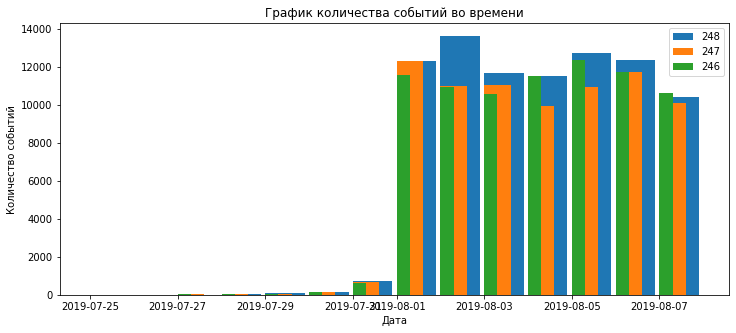

In [18]:
counts246=log246['event_name'].groupby(log246['date']).count().reset_index()
counts247=log247['event_name'].groupby(log247['date']).count().reset_index()
counts248=log248['event_name'].groupby(log248['date']).count().reset_index()

plt.figure(figsize=(12,5))

plt.bar(counts248['date'],counts248['event_name'], label='248', width=0.9, align='edge')
plt.bar(counts247['date'],counts247['event_name'], label='247', width=0.6, align='edge')
plt.bar(counts246['date'],counts246['event_name'], label='246', width=0.3, align='edge')

plt.legend() 
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.title('График количества событий во времени')
plt.show()

**Выводы:**\
На графике количества событий по датам видно, что количество данных с 25 по 30 июля сильно уступает количеству данных в августе. Скорее всего данные "доехали" именно к 1 августа, данные до 1го августа убираем.
    

In [19]:
log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   device_id   243713 non-null  int64         
 2   datetime    243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 19.2+ MB


In [20]:
log['date'] = pd.to_datetime(log['date'])
new_log = log.query('date > "2019-07-31"')
print('Удалено строк датафрейма -', log.shape[0] - new_log.shape[0], 
      ', удалено в процентах -',
      round(((log.shape[0] - new_log.shape[0])/log.shape[0])*100,2), '%')


Удалено строк датафрейма - 2826 , удалено в процентах - 1.16 %


In [21]:
lost_id = 0
for row in new_log:
    if row not in log['device_id'].unique():
        lost_id +=1 
        
print('Удалено данных о пользователях -',lost_id,
     ', удалено в процентах -',
      round((lost_id/log['device_id'].nunique())*100,2), '%')

Удалено данных о пользователях - 5 , удалено в процентах - 0.07 %


/tmp/ipykernel_79/3552053160.py:3: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if row not in log['device_id'].unique():


In [22]:
new_log.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240887 entries, 2828 to 244125
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  240887 non-null  object        
 1   device_id   240887 non-null  int64         
 2   datetime    240887 non-null  datetime64[ns]
 3   group       240887 non-null  int64         
 4   date        240887 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.0+ MB


In [23]:
new_groups = new_log.pivot_table(index='group',values='device_id',aggfunc='nunique')
new_groups
#количество пользователей в каждой экспериментальной группе

,device_id
group,
246,2484
247,2513
248,2537


**Вывод по разделу 3:**\
После обработки данных в логе осталось всего 243 713 записей о 7 551 пользователе. В среднем на одного пользователя приходится 32 события.\
Согласно графику количества событий в каждую дату, может сделать вывод, что реальный период оценки данных - 7 дней с 1-го по 7-е августа 2019 года. В окончательный датафрейм для дальнейшего анализа не попало 2826 записей (около 1% от общего объема данных) и данные о 5-ти пользователях (менее 1% от общего количества пользователей).\
\
В обновлённом датафрейме new_log - 240 887 записей, включены данные о примерно одинаковом количестве пользователей из всех 3-х групп.

### Анализ воронки событий

<a id='c'></a>

In [24]:
new_log['event_name'].value_counts().sort_values(ascending=False)

#частота событий в логе

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [25]:
events = new_log.pivot_table(index='event_name',values='device_id',aggfunc='nunique').sort_values(
    by = 'device_id', ascending = False)
events

#количество уникальных пользователей, совершивших событие хотя бы раз

,device_id
event_name,
MainScreenAppear,7419
OffersScreenAppear,4593
CartScreenAppear,3734
PaymentScreenSuccessful,3539
Tutorial,840


In [26]:
events['user%'] = round(events['device_id']/len(new_log['device_id'].unique()) * 100,2)
events

#доля уникальных пользователей, совершивших событие хотя бы раз

,device_id,user%
event_name,,
MainScreenAppear,7419,98.47
OffersScreenAppear,4593,60.96
CartScreenAppear,3734,49.56
PaymentScreenSuccessful,3539,46.97
Tutorial,840,11.15


**Воронка событий пользователя:**
1. MainScreenAppear - вход на главный экран
2. OffersScreenAppear - вход на страницу товара
3. CartScreenAppear - вход в корзину
4. PaymentScreenSuccessful - оплата заказа пользователем\
\
Из общей цепочки выбивается событие 'Tutorial' - обучение. Опциональное обучение вероятно не входит в воронку событий, значит, данные в дальнейшем анализе можно не учитывать.

In [27]:
events.drop(['Tutorial'], inplace=True)

#удаляем данные об обучении из дф

In [28]:
events['next%'] = 0
for i in range(0, len(events['user%'])):
    if i == 0:
        events['next%'].iloc[i] = 100
    else:
        events['next%'].iloc[i] = round(int(events['device_id'].iloc[i]) / int(events['device_id'].iloc[i-1])*100,2)

events

#для каждого события считаем долю пользователей, перешедших на следующий шаг воронки

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,device_id,user%,next%
event_name,,,
MainScreenAppear,7419,98.47,100.00
OffersScreenAppear,4593,60.96,61.91
CartScreenAppear,3734,49.56,81.30
PaymentScreenSuccessful,3539,46.97,94.78


In [29]:
print('С первого до последнего шага воронки доходят -', 
      round(((events['device_id'][0]-events['device_id'][3])/events['device_id'][0])*100,2), '%')

С первого до последнего шага воронки доходят - 52.3 %


**Выводы по разделу 4:**\
В датафрейме присутствует 5 событий:
* MainScreenAppear - вход на главный экран
* OffersScreenAppear - вход на страницу товара
* CartScreenAppear - вход в корзину
* PaymentScreenSuccessful - оплата заказа пользователем
* Tutorial - обучение\
\
Наиболее популярное по количеству записей MainScreenAppear - почти половина от общего объема, наименее Tutorial  - менее 1%.\
С точки зрения количества уникальных пользователей, совершивших событие, MainScreenAppear также лидирует - 98% пользователей, а Tutorial также отстаёт - 11% пользователей.\
\
Воронка событий пользователя:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful\
\
Событие Tutorial - вероятно опциональное и не входит в воронку событий, поэтому данные об этом событии в дальнейшем анализе воронки было решено не учитывать.\
\
От начала до конца воронку проходит *52% пользователей*, больше всего потенциальных покупателей теряется при переходе с шага MainScreenAppear на шаг OffersScreenAppear - *почти 40% пользователей не переходят с главного экрана на страницу товара*.

### Анализ результатов эксперимента

#### Подготовка к анализу

<a id='d'></a>

In [30]:
new_groups=new_log.pivot_table(index='group',values='device_id',aggfunc='nunique')
new_groups

#общее количество пользователей в каждой группе

,device_id
group,
246,2484
247,2513
248,2537


In [31]:
funnel = new_log.pivot_table(index='group',columns = 'event_name', values='device_id',aggfunc='nunique')

del funnel['Tutorial']

funnel

#количество пользователей на каждом этапе вронки по группам

event_name,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
group,,,,
246,1266,2450,1542,1200
247,1238,2476,1520,1158
248,1230,2493,1531,1181


In [32]:
round((funnel['MainScreenAppear']/new_groups['device_id'])*100,2)

#доля пользователей совершивших самое популярное событие MainScreenAppear в каждой группе

group
246    98.63
247    98.53
248    98.27
dtype: float64

In [33]:
new_groups = new_groups.reset_index()
funnel = funnel.reset_index()

In [34]:
def st_test (prev, final, alpha):
    p1 = prev[0] / final[0]
    p2 = prev[1] / final[1]
    p_total = (prev[0] + prev[1]) / (final[0] + final[1])
    difference = p1 - p2
 
    z_value = difference / mth.sqrt(p_total *(1-p_total) * (1/final[0] + 1/final[1]))
    distr = stats.norm(0, 1) 
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print('p-value: ', p_value)
    
    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу")
        print('')
    else:
        print("Не получилось отвергнуть нулевую гипотезу")
        print('')
        
#функция для проверки статистических гипотез

In [35]:
def cycle (group1, group2, alpha):
    users_quantity = ([new_groups['device_id'][group1], new_groups['device_id'][group2]])
    MainScreenAppear_quantity = ([funnel['MainScreenAppear'][group1], funnel['MainScreenAppear'][group2]])
    OffersScreenAppear_quantity = ([funnel['OffersScreenAppear'][group1], funnel['OffersScreenAppear'][group2]])
    CartScreenAppear_quantity = ([funnel['CartScreenAppear'][group1], funnel['CartScreenAppear'][group2]])
    PaymentScreenSuccessful_quantity = ([funnel['PaymentScreenSuccessful'][group1], funnel['PaymentScreenSuccessful'][group2]])
    
    print('Результаты по MainScreenAppear')
    st_test(MainScreenAppear_quantity, users_quantity, alpha)
    
    print('Результаты по OffersScreenAppear')
    st_test(OffersScreenAppear_quantity, users_quantity, alpha)
    
    print('Результаты по CartScreenAppear')
    st_test(CartScreenAppear_quantity, users_quantity, alpha)
    
    print('Результаты по PaymentScreenSuccessful')
    st_test(PaymentScreenSuccessful_quantity, users_quantity, alpha)
    
#функция для проверки статистических гипотез по всем типам событий

#### A/A-тест

<a id='e'></a>

H0: статистически значимых различий в долях пользователей совершивших действие между группами 246 и 247 нет.\
H1: статистически значимые различия в долях пользователей совершивших действие между группами 246 и 247 есть.

In [36]:
cycle (0, 1, 0.05)

Результаты по MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



**Выводы A/A-тест:**\
p-value выше уровня значимости 5% по каждому событию - значит, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между контрольными группами. Различия в показателях не являются статистически значимыми.\
\
Можно сделать вывод, что разбиение на группы работает корректно.

#### A/A/B-тест

<a id='f'></a>

**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между группами 246 и 248 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между группами 246 и 248 есть.

In [37]:
cycle (0, 2, 0.05)

Результаты по MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



**Выводы A/B-тест (246/248):**\
p-value выше уровня значимости 5% по всем событиям  - значит, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между группами. Различия в показателях не являются статистически значимыми.

**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между группами 247 и 248 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между группами 247 и 248 есть.

In [38]:
cycle (1, 2, 0.05)

Результаты по MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



**Выводы A/B-тест (247/248):**\
p-value выше уровня значимости 5% по каждому событию - значит, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между группами. Различия в показателях по каждому событию между группами не являются статистически значимыми.

In [39]:
funnel.loc[3]=[249,
              funnel['CartScreenAppear'][0]+funnel['CartScreenAppear'][1],
               funnel['MainScreenAppear'][0]+funnel['MainScreenAppear'][1], 
               funnel['OffersScreenAppear'][0]+funnel['OffersScreenAppear'][1],
              funnel['PaymentScreenSuccessful'][0]+funnel['PaymentScreenSuccessful'][1]]
funnel

#создание строки для объединенной группы из двух групп: 246 + 247 = 249

event_name,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful
0,246,1266,2450,1542,1200
1,247,1238,2476,1520,1158
2,248,1230,2493,1531,1181
3,249,2504,4926,3062,2358


In [40]:
new_groups.loc[3]=[249,new_groups['device_id'][0]+new_groups['device_id'][1]]
new_groups

#создание строки для объединенного количества пользователей двух групп: 246 + 247 = 249

,group,device_id
0,246,2484
1,247,2513
2,248,2537
3,249,4997


**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между объединённой группой и  группой 248 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между объединённой группой и  группой 248 есть.

In [41]:
cycle (3, 2, 0.05)

Результаты по MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



**Выводы A/B-тест (объединённая группа/248):**\
p-value выше уровня значимости 5% по каждому событию - значит, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между группами. Различия в показателях по каждому событию между группами не являются статистически значимыми.

**Выводы A/A/B-тест (уровень стат. значимости = 0.05):**\
В целом, результаты тестов показали, что при уровне статистической значимости - 0.05, доли пользователей совершивших какое-либо действие не отличаются между всеми 3-мя группами.\
Таким образом, согласно тестам, изменение шрифта приложения вероятно не повлияет на поведение пользователей.

#### A/A-тест (уровень стат. значимости = 0.1)

**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между группами 246 и 247 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между группами 246 и 247 есть.

In [42]:
cycle (0, 1, 0.1)

Результаты по MainScreenAppear
p-value:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу



**Выводы A/A-тест:**\
p-value выше уровня значимости 10% по каждому событию - значит, также, как и ранее, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между контрольными группами. Различия в показателях не являются статистически значимыми.

#### A/A/B-тест (уровень стат. значимости = 0.1)

**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между группами 246 и 248 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между группами 246 и 248 есть.

In [43]:
cycle (0, 2, 0.1)

Результаты по MainScreenAppear
p-value:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.07842923237520116
Отвергаем нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу



**Выводы A/B-тест (246/248):**\
p-value выше уровня значимости 5% по 3-м из 4-х событий  - значит, по ним мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между группами. Различия в показателях не являются статистически значимыми.\
\
Статистически значимые различия присутствуют только на этапе воронки CartScreenAppear.

**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между группами 247 и 248 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между группами 247 и 248 есть.

In [44]:
cycle (1, 2, 0.1)

Результаты по MainScreenAppear
p-value:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу



**Выводы A/B-тест (247/248):**\
p-value выше уровня значимости 5% по каждому событию - значит, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между группами. Различия в показателях по каждому событию между группами не являются статистически значимыми.

**H0**: статистически значимых различий в среднем количестве пользователей совершивших действие между объединённой группой и  группой 248 нет.\
**H1**: статистически значимые различия в среднем количестве пользователей совершивших действие между объединённой группой и  группой 248 есть.

In [45]:
cycle (3, 2, 0.1)

Результаты по MainScreenAppear
p-value:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу

Результаты по OffersScreenAppear
p-value:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу

Результаты по CartScreenAppear
p-value:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу

Результаты по PaymentScreenSuccessful
p-value:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу



**Выводы A/B-тест (объединённая группа/248):**\
p-value выше уровня значимости 5% по каждому событию - значит, мы не отвергаем нулевую гипотезу об отсутствии различий в долях пользователей совершивших действие между группами. Различия в показателях по каждому событию между группами не являются статистически значимыми.

**Выводы A/A/B-тест (уровень стат. значимости = 0.1):**\
В целом, результаты тестов показали, что при уровнях статистической значимости - 0.1 и 0.05, доли пользователей совершивших какое-либо действие практически не отличаются между всеми 3-мя группами.\
Таким образом, согласно тестам, изменение шрифта приложения вероятно практически не повлияет на поведение пользователей.

### Общий вывод

<a id='g'></a>

В ходе исследования были рассмотрены **данные стартапа по продаже продуктов питания с 1 по 7 августа 2019 года**: лог с данными и пользователях, воронка продаж, результаты A/A/B-эксперимента.


После обработки данных в логе осталось всего 243 713 записей о 7 551 пользователе. В среднем на одного пользователя приходится 32 события.\
Важно отметить, что первичная версия датафрейма состояла из данных с 25 июля по 2 августа, однако, по результатам исследования, выяснилось, что реальный период оценки данных - 7 дней с 1-го по 7-е августа 2019 года (99% данных).\
\
В обновлённом датафрейме, подготовленном для дальнейшего анализа воронки и экспериментов, - 240 887 записей, включены данные о примерно одинаковом количестве пользователей из всех **3-х групп: 246, 247(контрольные группы) и 248**.

Всего в датафрейме были обнаружены записи о 5-ти событиях:
* MainScreenAppear - вход на главный экран
* OffersScreenAppear - вход на страницу товара
* CartScreenAppear - вход в корзину
* PaymentScreenSuccessful - оплата заказа пользователем
* Tutorial - обучение\
\
В ходе анализа, была сформирована воронка событий пользователя:
1. MainScreenAppear
2. OffersScreenAppear
3. CartScreenAppear
4. PaymentScreenSuccessful\
\
(*Событие Tutorial - вероятно опциональное и не входит в воронку событий*).\
\
От начала до конца воронку проходит **52% пользователей**, больше всего потенциальных покупателей теряется при переходе с шага MainScreenAppear на шаг OffersScreenAppear - **почти 40% пользователей не переходят с главного экрана на страницу товара**.

В ходе A/A/B-эксперимента были проведены тесты с уровнем значимости *5% и 10%*, направленные на сравнение долей пользователей, совершающих определенные действия в 3-х группах.\
\
Результаты *A/A-теста* показали, что статистически-значимых различий между контрольными группами (246 и 247) нет. Значит, **данные разбиты по группам корректно**.\
\
По результатам A/B-тестов, доли пользователей совершивших какое-либо действие **практически не отличаются между группами A (246,247) и группой B (248)**, для которой шрифты во всём приложении изменились.

Таким образом, **обновление шрифтов во всем приложении значимо не повлияет на существующее поведение пользователя в приложении**.